# License

Copyright 2020 Hamaad Musharaf Shah

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# Automatic feature engineering using deep learning and Bayesian inference
## Author: Hamaad Shah

We will explore the use of autoencoders for automatic feature engineering. The idea is to automatically learn a set of features from raw data in an unsupervised manner that can be useful later in supervised learning tasks. Unlabelled data is inexpensive to obtain in large quantities therefore training a feature extractor in an unsupervised manner is a powerful first step towards later training supervised learning models which perhaps may not have access to a large amount of labelled data.

## Computer Vision

We will use the MNIST dataset for this purpose where the raw data is a 2 dimensional tensor of pixel intensities per image. The image is our unit of analysis: We will predict the probability of each class for each image. This is a multiclass classification task and we will use the accuracy score to assess model performance on the test fold.

![](pixel_lattice.png)

In [1]:
import inspect

import numpy as np

np.set_printoptions(suppress=True)

import pandas as pd

import tensorflow as tf

gpu_devices = tf.config.list_physical_devices(device_type="GPU")
tf.config.experimental.set_memory_growth(device=gpu_devices[0], enable=True)

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import norm

import matplotlib.pyplot as plt
import plotnine

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU: {gpu_devices}")

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = (
    x_train.astype(dtype="float32") / 255.0,
    x_test.astype(dtype="float32") / 255.0,
)

y_train = y_train.ravel()
y_test = y_test.ravel()

class_per_label_size = 100
sampled_class_ids = np.concatenate(
    [
        [
            np.random.choice(
                a=np.arange(start=0, stop=y_train.shape[0], step=1)[
                    y_train == class_label
                ],
                size=class_per_label_size,
                replace=False,
            )
        ]
        for class_label in np.unique(ar=y_train)
    ],
    axis=0,
)
sampled_x_train = np.concatenate(
    [x_train[these_class_ids, :, :] for these_class_ids in sampled_class_ids], axis=0
)
sampled_y_train = np.concatenate(
    [y_train[these_class_ids] for these_class_ids in sampled_class_ids], axis=0
)

TensorFlow version: 2.5.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## MNIST: No Autoencoders

We run the MNIST dataset without using an autoencoder. The 2 dimensional tensor of pixel intensities per image for MNIST images are of dimension $\mathbb{R}^{28 \times 28}$. We reshape them as a 1 dimensional tensor of dimension $\mathbb{R}^{784}$ per image. Therefore we have 784, i.e., $28 \times 28 = 784$, features for this supervised learning task per image.

### Results

The accuracy score for the MNIST classification task without autoencoders: 87.09%.

In [2]:
pipe_base = Pipeline(
    steps=[
        ("scaler", MinMaxScaler(feature_range=(0.0, 1.0))),
        (
            "classifier",
            linear_model.LogisticRegression(max_iter=10000, random_state=666),
        ),
    ]
)

pipe_base.fit(
    X=sampled_x_train.reshape(
        sampled_x_train.shape[0], sampled_x_train.shape[1] * sampled_x_train.shape[2]
    ),
    y=sampled_y_train,
)

acc_base = pipe_base.score(
    X=x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2]), y=y_test
)

print(
    "The accuracy score for the MNIST classification task without autoencoders: %.6f%%."
    % (acc_base * 100)
)

The accuracy score for the MNIST classification task without autoencoders: 80.000000%.


In [3]:
tsne = TSNE(n_components=2)
test_encoded_df = pd.DataFrame(
    data=tsne.fit_transform(
        X=x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])
    ),
    columns=["Encoding_1", "Encoding_2"],
)
test_encoded_df["Target"] = y_test

cluster_plot = (
    plotnine.ggplot(data=test_encoded_df)
    + plotnine.geom_point(
        mapping=plotnine.aes(x="Encoding_1", y="Encoding_2", fill="factor(Target)"),
        size=2,
        color="black",
    )
    + plotnine.xlab(xlab="Encoding dimension 1")
    + plotnine.ylab(ylab="Encoding dimension 2")
    + plotnine.ggtitle(title="No autoencoder with 2-dimensional encoding")
    + plotnine.theme_matplotlib()
)

cluster_plot.save(
    filename="/home/hamaad/Projects/autoencoders_tensorflow/no_autoencoders_plot.png",
    height=6,
    width=8,
)

/home/hamaad/.local/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 8 x 6 in image.
/home/hamaad/.local/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /home/hamaad/Projects/autoencoders_tensorflow/no_autoencoders_plot.png
/home/hamaad/.local/lib/python3.8/site-packages/plotnine/themes/theme.py:250: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.


/home/hamaad/.local/lib/python3.8/site-packages/plotnine/themes/theme.py:250: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.


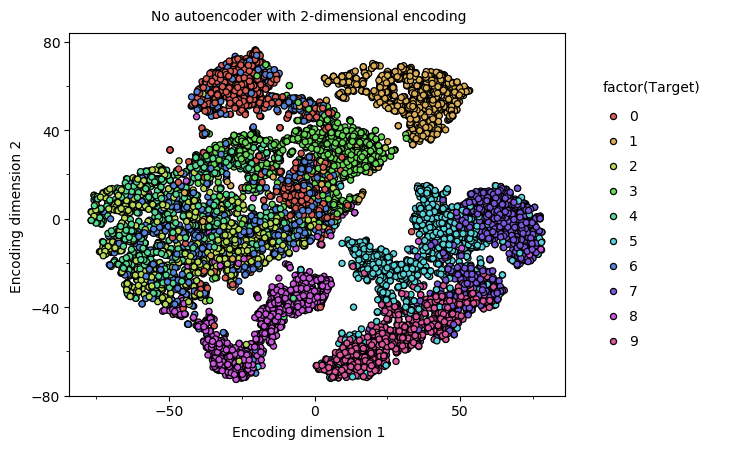

<ggplot: (8789852779352)>

In [4]:
cluster_plot

![](no_autoencoders_plot.png)

## MNIST: PCA

We use a PCA filter that picks the number of components that explain $99\%$ of the variation.

### Results

The accuracy score for the MNIST classification task with PCA: 79.00%.

In [19]:
pca = PCA(n_components=0.99)
pca.fit(X=x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2]))

pipe_pca = Pipeline(
    steps=[
        ("scaler", MinMaxScaler(feature_range=(0.0, 1.0))),
        (
            "classifier",
            linear_model.LogisticRegression(max_iter=10000, random_state=666),
        ),
    ]
)

pipe_pca.fit(
    X=pca.transform(
        X=sampled_x_train.reshape(
            sampled_x_train.shape[0],
            sampled_x_train.shape[1] * sampled_x_train.shape[2],
        )
    ),
    y=sampled_y_train,
)

acc_pca = pipe_pca.score(
    X=pca.transform(
        X=x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])
    ),
    y=y_test,
)

print(
    "The accuracy score for the MNIST classification task with PCA: %.6f%%."
    % (acc_pca * 100)
)

The accuracy score for the MNIST classification task with PCA: 75.130000%.


/home/hamaad/.local/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 8 x 6 in image.
/home/hamaad/.local/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /home/hamaad/Projects/autoencoders_tensorflow/pca_plot.png
/home/hamaad/.local/lib/python3.8/site-packages/plotnine/themes/theme.py:250: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
/home/hamaad/.local/lib/python3.8/site-packages/plotnine/themes/theme.py:250: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.


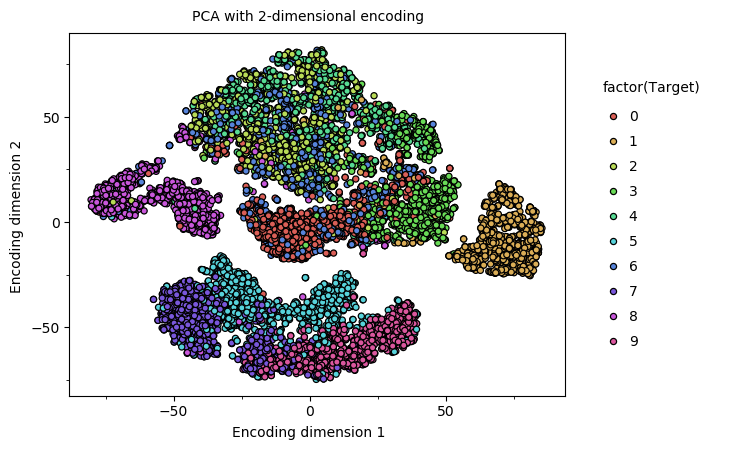

<ggplot: (8756080171798)>

In [10]:
tsne = TSNE(n_components=2)
test_encoded_df = pd.DataFrame(
    data=tsne.fit_transform(
        X=pca.transform(
            x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])
        )
    ),
    columns=["Encoding_1", "Encoding_2"],
)
test_encoded_df["Target"] = y_test

cluster_plot = (
    plotnine.ggplot(data=test_encoded_df)
    + plotnine.geom_point(
        mapping=plotnine.aes(x="Encoding_1", y="Encoding_2", fill="factor(Target)"),
        size=2,
        color="black",
    )
    + plotnine.xlab(xlab="Encoding dimension 1")
    + plotnine.ylab(ylab="Encoding dimension 2")
    + plotnine.ggtitle(title="PCA with 2-dimensional encoding")
    + plotnine.theme_matplotlib()
)

cluster_plot.save(
    filename="/home/hamaad/Projects/autoencoders_tensorflow/pca_plot.png",
    height=6,
    width=8,
)

cluster_plot

![](pca_plot.png)

## MNIST: Vanilla Autoencoders

An autoencoder is an unsupervised learning technique where the objective is to learn a set of features that can be used to reconstruct the input data.

Our input data is $X \in \mathbb{R}^{N \times 784}$. An encoder function $E$ maps this to a set of $K$ features such that $E: \mathbb{R}^{N \times 784} \rightarrow \mathbb{R}^{N \times K}$. A decoder function $D$ uses the set of $K$ features to reconstruct the input data such that $D: \mathbb{R}^{N \times K} \rightarrow \mathbb{R}^{N \times 784}$. 

\begin{align*}
&X \in \mathbb{R}^{N \times 784} \\
&E: \mathbb{R}^{N \times 784} \rightarrow \mathbb{R}^{N \times K} \\
&D: \mathbb{R}^{N \times K} \rightarrow \mathbb{R}^{N \times 784}
\end{align*}
    
Lets denote the reconstructed data as $\tilde{X} = D(E(X))$. The goal is to learn the encoding and decoding functions such that we minimize the difference between the input data and the reconstructed data. An example for an objective function for this task can be the Mean Squared Error (MSE) such that $\frac{1}{N}||\tilde{X} - X||^{2}_{2}$. 
    
We learn the encoding and decoding functions by minimizing the MSE using the parameters that define the encoding and decoding functions: The gradient of the MSE with respect to the parameters are calculated using the chain rule, i.e., backpropagation, and used to update the parameters via an optimization algorithm such as Stochastic Gradient Descent (SGD). 

Lets assume we have a single layer autoencoder using the Exponential Linear Unit (ELU) activation function, batch normalization, dropout and the Adaptive Moment (Adam) optimization algorithm. $B$ is the batch size, $K$ is the number of features.

* **Exponential Linear Unit:** The activation function is smooth everywhere and avoids the vanishing gradient problem as the output takes on negative values when the input is negative. $\alpha$ is taken to be $1.0$.

\begin{align*}
H_{\alpha}(z) &= 
\begin{cases}
&\alpha\left(\exp(z) - 1\right) \quad \text{if} \quad z < 0 \\
&z \quad \text{if} \quad z \geq 0
\end{cases} \\
\frac{dH_{\alpha}(z)}{dz} &= 
\begin{cases}
&\alpha\left(\exp(z)\right) \quad \text{if} \quad z < 0 \\
&1 \quad \text{if} \quad z \geq 0
\end{cases} 
\end{align*}

* **Batch Normalization:** The idea is to transform the inputs into a hidden layer's activation functions. We standardize or normalize first using the mean and variance parameters on a per feature basis and then learn a set of scaling and shifting parameters on a per feature basis that transforms the data. The following equations describe this layer succintly: The parameters we learn in this layer are $\left(\mu_{j}, \sigma_{j}^2, \beta_{j}, \gamma_{j}\right) \quad \forall j \in \{1, \dots, K\}$.

\begin{align*}
\mu_{j} &= \frac{1}{B} \sum_{i=1}^{B} X_{i,j} \quad &\forall j \in \{1, \dots, K\} \\
\sigma_{j}^2 &= \frac{1}{B} \sum_{i=1}^{B} \left(X_{i,j} - \mu_{j}\right)^2 \quad &\forall j \in \{1, \dots, K\} \\
\hat{X}_{:,j} &= \frac{X_{:,j} - \mu_{j}}{\sqrt{\sigma_{j}^2 + \epsilon}} \quad &\forall j \in \{1, \dots, K\} \\
Z_{:,j} &= \gamma_{j}\hat{X}_{:,j} + \beta_{j} \quad &\forall j \in \{1, \dots, K\}
\end{align*}

* **Dropout:** This regularization technique simply drops the outputs from input and hidden units with a certain probability say $50\%$. 

* **Adam Optimization Algorithm:** This adaptive algorithm combines ideas from the Momentum and RMSProp optimization algorithms. The goal is to have some memory of past gradients which can guide future parameters updates. The following equations for the algorithm succintly describe this method assuming $\theta$ is our set of parameters to be learnt and $\eta$ is the learning rate.

\begin{align*}
m &\leftarrow \beta_{1}m + \left[\left(1 - \beta_{1}\right)\left(\nabla_{\theta}\text{MSE}\right)\right] \\
s &\leftarrow \beta_{2}s + \left[\left(1 - \beta_{2}\right)\left(\nabla_{\theta}\text{MSE} \otimes \nabla_{\theta}\text{MSE} \right)\right] \\
\theta &\leftarrow \theta - \eta m \oslash \sqrt{s + \epsilon}
\end{align*}

### Results

The accuracy score for the MNIST classification task with an autoencoder: 90.98%.

In [5]:
class VanillaAutoencoder(tf.keras.Model):
    def __init__(self, num_feat, num_hidden, num_encoding, dropout_rate):
        super().__init__()

        args, _, _, values = inspect.getargvalues(frame=inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)

        self.encoder = tf.keras.Sequential(
            layers=[
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation="relu",
                ),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(units=self.num_hidden, activation="relu"),
                tf.keras.layers.Dropout(rate=self.dropout_rate),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(units=self.num_hidden, activation="relu"),
                tf.keras.layers.Dropout(rate=self.dropout_rate),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(units=self.num_encoding, activation="relu"),
            ]
        )

        self.decoder = tf.keras.Sequential(
            layers=[
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation="elu",
                ),
                tf.keras.layers.Dropout(rate=self.dropout_rate),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(units=self.num_hidden, activation="elu"),
                tf.keras.layers.Dropout(rate=self.dropout_rate),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(units=self.num_feat, activation="sigmoid"),
            ]
        )

    def call(self, x):
        encoding = self.encoder(x)
        return self.decoder(encoding)

In [6]:
autoencoder = VanillaAutoencoder(
    num_feat=x_train.shape[1] * x_train.shape[2],
    num_hidden=400,
    num_encoding=200,
    dropout_rate=0.5,
)
reconstruction_loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)
train_loss = tf.keras.metrics.Mean(name="train_loss")
test_loss = tf.keras.metrics.Mean(name="test_loss")

batch_size = 100
train_ds = (
    tf.data.Dataset.from_tensor_slices(
        tensors=(
            x_train.reshape(
                x_train.shape[0],
                x_train.shape[1] * x_train.shape[2],
            ),
            x_train.reshape(
                x_train.shape[0],
                x_train.shape[1] * x_train.shape[2],
            ),
        )
    )
    .shuffle(buffer_size=10000, reshuffle_each_iteration=True)
    .batch(batch_size=batch_size)
)
test_ds = tf.data.Dataset.from_tensor_slices(
    tensors=(
        x_test.reshape(
            x_test.shape[0],
            x_test.shape[1] * x_test.shape[2],
        ),
        x_test.reshape(
            x_test.shape[0],
            x_test.shape[1] * x_test.shape[2],
        ),
    )
).batch(batch_size=batch_size)


@tf.function
def train_step(x, truth, model):
    with tf.GradientTape() as tape:
        decoding = model(x=x, training=True)
        loss = reconstruction_loss(y_true=truth, y_pred=decoding)
    gradients = tape.gradient(target=loss, sources=model.trainable_variables)
    optimizer.apply_gradients(grads_and_vars=zip(gradients, model.trainable_variables))
    train_loss(loss)


@tf.function
def test_step(x, truth, model):
    decoding = model(x=x, training=False)
    loss = reconstruction_loss(y_true=truth, y_pred=decoding)
    test_loss(loss)


num_epochs = 50
for epoch in range(num_epochs):
    train_loss.reset_states()
    test_loss.reset_states()

    for x, truth in train_ds:
        train_step(x=x, truth=truth, model=autoencoder)
    for x, truth in test_ds:
        test_step(x=x, truth=truth, model=autoencoder)

    print("Epoch:", epoch + 1)
    print("Train loss:", train_loss.result())
    print("Test loss:", test_loss.result())

Epoch: 1
Train loss: tf.Tensor(0.046605345, shape=(), dtype=float32)
Test loss: tf.Tensor(0.0238512, shape=(), dtype=float32)
Epoch: 2
Train loss: tf.Tensor(0.027921654, shape=(), dtype=float32)
Test loss: tf.Tensor(0.021126408, shape=(), dtype=float32)
Epoch: 3
Train loss: tf.Tensor(0.02605293, shape=(), dtype=float32)
Test loss: tf.Tensor(0.01959686, shape=(), dtype=float32)
Epoch: 4
Train loss: tf.Tensor(0.024994528, shape=(), dtype=float32)
Test loss: tf.Tensor(0.019175818, shape=(), dtype=float32)
Epoch: 5
Train loss: tf.Tensor(0.024274485, shape=(), dtype=float32)
Test loss: tf.Tensor(0.018209048, shape=(), dtype=float32)
Epoch: 6
Train loss: tf.Tensor(0.023786971, shape=(), dtype=float32)
Test loss: tf.Tensor(0.018034639, shape=(), dtype=float32)
Epoch: 7
Train loss: tf.Tensor(0.023425443, shape=(), dtype=float32)
Test loss: tf.Tensor(0.017597338, shape=(), dtype=float32)
Epoch: 8
Train loss: tf.Tensor(0.023052506, shape=(), dtype=float32)
Test loss: tf.Tensor(0.01728475, shape=

In [7]:
pipe_autoencoder = Pipeline(
    steps=[
        ("scaler", MinMaxScaler(feature_range=(0.0, 1.0))),
        (
            "classifier",
            linear_model.LogisticRegression(max_iter=10000, random_state=666),
        ),
    ]
)

with tf.device(device_name="/CPU:0"):
    pipe_autoencoder.fit(
        X=autoencoder.encoder(
            sampled_x_train.reshape(
                sampled_x_train.shape[0],
                sampled_x_train.shape[1] * sampled_x_train.shape[2],
            )
        ),
        y=sampled_y_train,
    )
    acc_autoencoder = pipe_autoencoder.score(
        X=autoencoder.encoder(
            x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])
        ),
        y=y_test,
    )

print(
    "The accuracy score for the MNIST classification task with an autoencoder: %.6f%%."
    % (acc_autoencoder * 100)
)

The accuracy score for the MNIST classification task with an autoencoder: 80.940000%.


In [ ]:
tsne = TSNE(n_components=2)
with tf.device(device_name="/CPU:0"):
    test_encoded_df = pd.DataFrame(
        data=tsne.fit_transform(
            X=autoencoder.encoder(
                x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])
            )
        ),
        columns=["Encoding_1", "Encoding_2"],
    )
test_encoded_df["Target"] = y_test

cluster_plot = (
    plotnine.ggplot(data=test_encoded_df)
    + plotnine.geom_point(
        mapping=plotnine.aes(x="Encoding_1", y="Encoding_2", fill="factor(Target)"),
        size=2,
        color="black",
    )
    + plotnine.xlab(xlab="Encoding dimension 1")
    + plotnine.ylab(ylab="Encoding dimension 2")
    + plotnine.ggtitle(title="Autoencoder with 2-dimensional encoding")
    + plotnine.theme_matplotlib()
)
cluster_plot.save(
    filename="/home/hamaad/Projects/autoencoders_tensorflow/autoencoders_plot.png",
    height=6,
    width=8,
)

![](autoencoders_plot.png)

## MNIST: Denoising Autoencoders

The idea here is to add some noise to the data and try to learn a set of robust features that can reconstruct the non-noisy data from the noisy data. The MSE objective functions is as follows, $\frac{1}{N}||D(E(X + \epsilon)) - X||^{2}_{2}$, where $\epsilon$ is some noise term.

\begin{align*}
&X \in \mathbb{R}^{N \times 784} \\
&E: \mathbb{R}^{N \times 784} \rightarrow \mathbb{R}^{N \times K} \\
&D: \mathbb{R}^{N \times K} \rightarrow \mathbb{R}^{N \times 784}
\end{align*}

### Results

The accuracy score for the MNIST classification task with a denoising autoencoder: 90.98%.

In [ ]:
noise = 0.10 * np.random.uniform(
    low=0.0, high=1.0, size=batch_size * x_train.shape[1] * x_train.shape[2]
).reshape(batch_size, x_train.shape[1] * x_train.shape[2])


@tf.function
def train_step(x, truth, model):
    with tf.GradientTape() as tape:
        decoding = model(x=x, training=True)
        loss = reconstruction_loss(y_true=truth, y_pred=decoding)
    gradients = tape.gradient(target=loss, sources=model.trainable_variables)
    optimizer.apply_gradients(grads_and_vars=zip(gradients, model.trainable_variables))
    train_loss(loss)


@tf.function
def test_step(x, truth, model):
    decoding = model(x=x, training=False)
    loss = reconstruction_loss(y_true=truth, y_pred=decoding)
    test_loss(loss)


denoising_autoencoder = VanillaAutoencoder(
    num_feat=x_train.shape[1] * x_train.shape[2],
    num_hidden=400,
    num_encoding=200,
    dropout_rate=0.5,
)
reconstruction_loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)
train_loss = tf.keras.metrics.Mean(name="train_loss")
test_loss = tf.keras.metrics.Mean(name="test_loss")

num_epochs = 50
for epoch in range(num_epochs):
    train_loss.reset_states()
    test_loss.reset_states()

    for x, truth in train_ds:
        train_step(x=x + noise, truth=truth, model=denoising_autoencoder)
    for x, truth in test_ds:
        test_step(x=x + noise, truth=truth, model=denoising_autoencoder)

    print("Epoch:", epoch + 1)
    print("Train loss:", train_loss.result())
    print("Test loss:", test_loss.result())

pipe_denoising_autoencoder = Pipeline(
    steps=[
        ("scaler", MinMaxScaler(feature_range=(0.0, 1.0))),
        (
            "classifier",
            linear_model.LogisticRegression(max_iter=10000, random_state=666),
        ),
    ]
)

with tf.device(device_name="/CPU:0"):
    pipe_denoising_autoencoder.fit(
        X=denoising_autoencoder.encoder(
            sampled_x_train.reshape(
                sampled_x_train.shape[0],
                sampled_x_train.shape[1] * sampled_x_train.shape[2],
            )
        ),
        y=sampled_y_train,
    )
    acc_denoising_autoencoder = pipe_denoising_autoencoder.score(
        X=denoising_autoencoder.encoder(
            x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])
        ),
        y=y_test,
    )

print(
    "The accuracy score for the MNIST classification task with a denoising autoencoder: %.6f%%."
    % (acc_autoencoder * 100)
)

In [ ]:
tsne = TSNE(n_components=2)
with tf.device(device_name="/CPU:0"):
    test_encoded_df = pd.DataFrame(
        data=tsne.fit_transform(
            X=denoising_autoencoder.encoder(
                x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])
            )
        ),
        columns=["Encoding_1", "Encoding_2"],
    )
test_encoded_df["Target"] = y_test

cluster_plot = (
    plotnine.ggplot(data=test_encoded_df)
    + plotnine.geom_point(
        mapping=plotnine.aes(x="Encoding_1", y="Encoding_2", fill="factor(Target)"),
        size=2,
        color="black",
    )
    + plotnine.xlab(xlab="Encoding dimension 1")
    + plotnine.ylab(ylab="Encoding dimension 2")
    + plotnine.ggtitle(title="Denoising autoencoder with 2-dimensional encoding")
    + plotnine.theme_matplotlib()
)
cluster_plot.save(
    filename="/home/hamaad/Projects/autoencoders_tensorflow/denoising_autoencoders_plot.png",
    height=6,
    width=8,
)

![](denoising_autoencoders_plot.png)

## MNIST: 1 Dimensional Convolutional Autoencoders

So far we have used flattened or reshaped raw data. Such a 1 dimensional tensor of pixel intensities per image, $\mathbb{R}^{784}$, might not take into account useful spatial features that the 2 dimensional tensor, $\mathbb{R}^{28\times28}$, might contain. To overcome this problem, we introduce the concept of convolution filters, considering first their 1 dimensional version and then their 2 dimensional version. 

\begin{align*}
&X \in \mathbb{R}^{N \times 28 \times 28} \\
&E: \mathbb{R}^{N \times 28 \times 28} \rightarrow \mathbb{R}^{N \times K} \\
&D: \mathbb{R}^{N \times K} \rightarrow \mathbb{R}^{N \times 28 \times 28}
\end{align*}

The ideas behind convolution filters are closely related to handcrafted feature engineering: One can view the handcrafted features as simply the result of a predefined convolution filter, i.e., a convolution filter that has not been learnt based on the raw data at hand. 

Suppose we have raw transactions data per some unit of analysis, i.e., mortgages, that will potentially help us in classifying a unit as either defaulted or not defaulted. We will keep this example simple by only allowing the transaction values to be either \\$100 or \\$0. The raw data per unit spans 5 time periods while the defaulted label is for the next period, i.e., period 6. Here is an example of a raw data for a particular unit:

\begin{align*}
x = 
\begin{array}
{l}
\text{Period 1} \\ \text{Period 2} \\ \text{Period 3} \\ \text{Period 4} \\ \text{Period 5}
\end{array}
    \left[
    \begin{array}
    {c}
    \$0 \\ \$0 \\ \$100 \\ \$0 \\ \$0
    \end{array}
    \right]
\end{align*}

Suppose further that if the average transaction value is \\$20 then we will see a default in period 6 for this particular mortgage unit. Otherwise we do not see a default in period 6. The average transaction value is an example of a handcrafted feature: A predefined handcrafted feature that has not been learnt in any manner. It has been arrived at via domain knowledge of credit risk. Denote this as $\mathbf{H}(x)$.

The idea of learning such a feature is an example of a 1 dimensional convolution filter. As follows:

\begin{align*}
\mathbf{C}(x|\alpha) = \alpha_1 x_1 + \alpha_2 x_2 + \alpha_3 x_3 + \alpha_4 x_4 + \alpha_5 x_5
\end{align*}

Assuming that $\mathbf{H}(x)$ is the correct representation of the raw data for this supervised learning task then the optimal set of parameters learnt via supervised learning, or perhaps unsupervised learning and then transferred to the supervised learning task, i.e., transfer learning, for $\mathbf{C}(x|\alpha)$ is as follows where $\alpha$ is $\left[0.2, 0.2, 0.2, 0.2, 0.2\right]$:

\begin{align*}
\mathbf{C}(x|\alpha) = 0.2 x_1 + 0.2 x_2 + 0.2 x_3 + 0.2 x_4 + 0.2 x_5
\end{align*}

This is a simple example however this clearly illusrates the principle behind using deep learning for automatic feature engineering or representation learning. One of the main benefits of learning such a representation in an unsupervised manner is that the same representation can then be used for multiple supervised learning tasks: Transfer learning. This is a principled manner of learning a representation from raw data.

To summarize the 1 dimensional convolution filter for our simple example is defined as: 

\begin{align*}
\mathbf{C}(x|\alpha)&= x * \alpha \\
&= \sum_{t=1}^{5} x_t \alpha_t
\end{align*}

* $x$ is the input.
* $\alpha$ is the kernel.
* The output $x * \alpha$ is called a feature map and $*$ is the convolution operator or filter. This is the main difference between a vanilla neural network and a convolution neural network: We replace the matrix multiplication operator by the convolution operator.
* Depending on the task at hand we can have different types of convolution filters.
* Kernel size can be altered. In our example the kernel size is 5.
* Stride size can be altered. In our example we had no stride size however suppose that stride size was 1 and kernel size was 2, i.e., $\alpha = \left[\alpha_1, \alpha_2\right]$, then we would apply the kernel $\alpha$ at the start of the input, i.e., $\left[x_1, x_2\right] * \left[\alpha_1, \alpha_2\right]$, and move the kernel over the next area of the input, i.e., $\left[x_2, x_3\right] * \left[\alpha_1, \alpha_2\right]$, and so on and so forth until we arrive at a feature map that consists of 4 real values. This is called a valid convolution while a padded, i.e., say padded with zero values, convolution would give us a feature map that is the same size as the input, i.e., 5 real values in our example.
* We can apply an activation function to the feature maps such as ELU mentioned earlier.
* Finally we can summarize the information contained in feature maps by taking a maximum or average value over a defined portion of the feature map. For instance, if after using a valid convolution we arrive at a feature map of size 4 and then apply a max pooling operation with size 4 then we will be taking the maximum value of this feature map. The result is another feature map.

This automates feature engineering however introduces architecture engineering where different architectures consisting of various convolution filters, activation functions, batch normalization layers, dropout layers and pooling operators can be stacked together in a pipeline in order to learn a good representation of the raw data. One usually creates an ensemble of such architectures.

The goal behind convolutional autoencoders is to use convolution filters, activation functions, batch normalization layers, dropout layers and pooling operators to create an encoder function which will learn a good representation of our raw data. The decoder will also use a similar set of layers as the encoder to reconstruct the raw data with one exception: Instead of using a pooling operator it will use an upsampling operator. The basic idea behind the upsampling operator is to repeat an element a certain number of times say size 4: One can view this as the inverse operator to the pooling operator. The pooling operator is essentially a downsampling operator and the upsampling operator is simply the inverse of that in some sense.

### Results

The accuracy score for the MNIST classification task with a 1 dimensional convolutional autoencoder: 91.36%.

In [2]:
class ConvolutionalAutoencoder(tf.keras.Model):
    def __init__(
        self,
        filters,
        kernel_size,
        strides,
        pool_size,
        num_feat,
        dropout_rate,
    ):
        super().__init__()

        args, _, _, values = inspect.getargvalues(frame=inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)

        self.encoder = tf.keras.Sequential(
            layers=[
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv1D(
                    filters=self.filters,
                    kernel_size=self.kernel_size,
                    strides=self.strides,
                    activation="elu",
                    padding="same",
                ),
                tf.keras.layers.Dropout(rate=self.dropout_rate),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv1D(
                    filters=self.filters,
                    kernel_size=self.kernel_size,
                    strides=self.strides,
                    activation="elu",
                    padding="same",
                ),
                tf.keras.layers.Dropout(rate=self.dropout_rate),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv1D(
                    filters=self.filters,
                    kernel_size=self.kernel_size,
                    strides=self.strides,
                    activation="elu",
                    padding="same",
                ),
                tf.keras.layers.MaxPooling1D(strides=self.pool_size, padding="valid"),
            ]
        )

        self.decoder = tf.keras.Sequential(
            layers=[
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv1D(
                    filters=self.filters,
                    kernel_size=self.kernel_size,
                    strides=self.strides,
                    activation="elu",
                    padding="same",
                ),
                tf.keras.layers.UpSampling1D(size=self.pool_size),
                tf.keras.layers.Dropout(rate=self.dropout_rate),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv1D(
                    input_shape=(self.filters,),
                    filters=self.filters,
                    kernel_size=self.kernel_size,
                    strides=self.strides,
                    activation="elu",
                    padding="same",
                ),
                tf.keras.layers.Dropout(rate=self.dropout_rate),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv1D(
                    filters=self.filters,
                    kernel_size=self.kernel_size,
                    strides=self.strides,
                    activation="elu",
                    padding="same",
                ),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv1D(
                    filters=self.num_feat,
                    kernel_size=self.kernel_size,
                    strides=self.strides,
                    activation="sigmoid",
                    padding="same",
                ),
            ]
        )

    def call(self, x):
        encoding = self.encoder(x)
        return self.decoder(encoding)

In [3]:
@tf.function
def train_step(x, truth, model):
    with tf.GradientTape() as tape:
        decoding = model(x=x, training=True)
        loss = reconstruction_loss(y_true=truth, y_pred=decoding)
    gradients = tape.gradient(target=loss, sources=model.trainable_variables)
    optimizer.apply_gradients(grads_and_vars=zip(gradients, model.trainable_variables))
    train_loss(loss)


@tf.function
def test_step(x, truth, model):
    decoding = model(x=x, training=False)
    loss = reconstruction_loss(y_true=truth, y_pred=decoding)
    test_loss(loss)


convolutional_autoencoder = ConvolutionalAutoencoder(
    num_feat=x_train.shape[1],
    filters=50,
    kernel_size=8,
    strides=1,
    pool_size=4,
    dropout_rate=0.5,
)
reconstruction_loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)
train_loss = tf.keras.metrics.Mean(name="train_loss")
test_loss = tf.keras.metrics.Mean(name="test_loss")

batch_size = 100
train_ds = (
    tf.data.Dataset.from_tensor_slices(tensors=(x_train, x_train))
    .shuffle(buffer_size=10000, reshuffle_each_iteration=True)
    .batch(batch_size=batch_size)
)
test_ds = tf.data.Dataset.from_tensor_slices(tensors=(x_test, x_test)).batch(
    batch_size=batch_size
)

num_epochs = 50
for epoch in range(num_epochs):
    train_loss.reset_states()
    test_loss.reset_states()

    for x, truth in train_ds:
        train_step(x=x, truth=truth, model=convolutional_autoencoder)
    for x, truth in test_ds:
        test_step(x=x, truth=truth, model=convolutional_autoencoder)

    print("Epoch:", epoch + 1)
    print("Train loss:", train_loss.result())
    print("Test loss:", test_loss.result())

Epoch: 1
Train loss: tf.Tensor(0.034781374, shape=(), dtype=float32)
Test loss: tf.Tensor(0.01695534, shape=(), dtype=float32)
Epoch: 2
Train loss: tf.Tensor(0.01906175, shape=(), dtype=float32)
Test loss: tf.Tensor(0.014721396, shape=(), dtype=float32)
Epoch: 3
Train loss: tf.Tensor(0.017268425, shape=(), dtype=float32)
Test loss: tf.Tensor(0.012804274, shape=(), dtype=float32)
Epoch: 4
Train loss: tf.Tensor(0.016379686, shape=(), dtype=float32)
Test loss: tf.Tensor(0.012090133, shape=(), dtype=float32)
Epoch: 5
Train loss: tf.Tensor(0.015804568, shape=(), dtype=float32)
Test loss: tf.Tensor(0.012502961, shape=(), dtype=float32)
Epoch: 6
Train loss: tf.Tensor(0.015398532, shape=(), dtype=float32)
Test loss: tf.Tensor(0.011427534, shape=(), dtype=float32)
Epoch: 7
Train loss: tf.Tensor(0.015035822, shape=(), dtype=float32)
Test loss: tf.Tensor(0.011375637, shape=(), dtype=float32)
Epoch: 8
Train loss: tf.Tensor(0.014761839, shape=(), dtype=float32)
Test loss: tf.Tensor(0.010721488, sha

In [4]:
pipe_convolutional_autoencoder = Pipeline(
    steps=[
        ("scaler", MinMaxScaler(feature_range=(0.0, 1.0))),
        (
            "classifier",
            linear_model.LogisticRegression(max_iter=10000, random_state=666),
        ),
    ]
)

with tf.device(device_name="/CPU:0"):
    pipe_convolutional_autoencoder.fit(
        X=tf.keras.layers.Flatten(data_format="channels_last")(
            convolutional_autoencoder.encoder(sampled_x_train)
        ),
        y=sampled_y_train,
    )
    acc_convolutional_autoencoder = pipe_convolutional_autoencoder.score(
        X=tf.keras.layers.Flatten(data_format="channels_last")(
            convolutional_autoencoder.encoder(x_test)
        ),
        y=y_test,
    )

print(
    "The accuracy score for the MNIST classification task with a 1 dimensional convolutional autoencoder: %.6f%%."
    % (acc_convolutional_autoencoder * 100)
)

The accuracy score for the MNIST classification task with a 1 dimensional convolutional autoencoder: 80.870000%.


In [ ]:
tsne = TSNE(n_components=2)
with tf.device(device_name="/CPU:0"):
    test_encoded_df = pd.DataFrame(
        data=tsne.fit_transform(
            X=tf.keras.layers.Flatten(data_format="channels_last")(
                convolutional_autoencoder.encoder(x_test)
            )
        ),
        columns=["Encoding_1", "Encoding_2"],
    )
test_encoded_df["Target"] = y_test

cluster_plot = (
    plotnine.ggplot(data=test_encoded_df)
    + plotnine.geom_point(
        mapping=plotnine.aes(x="Encoding_1", y="Encoding_2", fill="factor(Target)"),
        size=2,
        color="black",
    )
    + plotnine.xlab(xlab="Encoding dimension 1")
    + plotnine.ylab(ylab="Encoding dimension 2")
    + plotnine.ggtitle(title="1D convolutional autoencoder with 2-dimensional encoding")
    + plotnine.theme_matplotlib()
)
cluster_plot.save(
    filename="/home/hamaad/Projects/autoencoders_tensorflow/convolutional_autoencoders_plot.png",
    height=6,
    width=8,
)

![](convolutional_autoencoders_plot.png)

## MNIST: Sequence to Sequence Autoencoders

Given our mortgage default example a potentially more useful deep learning architecture might be the Recurrent Neural Network (RNN), specifically their state of the art variant the Long Short Term Memory (LSTM) network. The goal is to explicitly take into account the sequential nature of the raw data.

\begin{align*}
&X \in \mathbb{R}^{N \times 28 \times 28} \\
&E: \mathbb{R}^{N \times 28 \times 28} \rightarrow \mathbb{R}^{N \times K} \\
&D: \mathbb{R}^{N \times K} \rightarrow \mathbb{R}^{N \times 28 \times 28}
\end{align*}

The gradients in a RNN depend on the parameter matrices defined for the model. Simply put these parameter matrices can end up being multiplied many times over and hence cause two major problems for learning: Exploding and vanishing gradients. If the spectral radius of the parameter matrices, i.e., the maximum absolute value of the eigenvalues of a matrix, is more than 1 then gradients can become large enough, i.e., explode in value, such that learning diverges and similarly if the spectral radius is less than 1 then gradients can become small, i.e., vanish in value, such that the next best transition for the parameters cannot be reliably calculated. Appropriate calculation of the gradient is important for estimating the optimal set of parameters that define a machine learning method and the LSTM network overcomes these problems in a vanilla RNN. We now define the LSTM network for 1 time step, i.e., 1 memory cell.

We calculate the value of the input gate, the value of the memory cell state at time period $t$ where $f(x)$ is some activation function and the value of the forget gate:

\begin{align*}
i_{t} &= \sigma(W_{i}x_{t} + U_{i}h_{t-1} + b_{i}) \\
\tilde{c_{t}} &= f(W_{c}x_{t} + U_{c}h_{t-1} + b_{c}) \\
f_{t} &= \sigma(W_{f}x_{t} + U_{f}h_{t-1} + b_{f})
\end{align*}

The forget gate controls the amount the LSTM remembers, i.e., the value of the memory cell state at time period $t-1$ where $\otimes$ is the hadamard product:

\begin{align*}
c_{t} = i_{t} \otimes \tilde{c_{t}} + f_{t} \otimes c_{t-1} 
\end{align*}

With the updated state of the memory cell we calculate the value of the outputs gate and finally the output value itself:

\begin{align*}
o_{t} &= \sigma(W_{o}x_{t} + U_{o}h_{t-1} + b_{o}) \\
h_{t} &= o_{t} \otimes f(c_{t})
\end{align*}

We can have a wide variety of LSTM architectures such as the convolutional LSTM where note that we replace the matrix multiplication operators in the input gate, the initial estimate $\tilde{c_{t}}$ of the memory cell state, the forget gate and the output gate by the convolution operator $*$:

\begin{align*}
i_{t} &= \sigma(W_{i} * x_{t} + U_{i} * h_{t-1} + b_{i}) \\
\tilde{c_{t}} &= f(W_{c} * x_{t} + U_{c} * h_{t-1} + b_{c}) \\
f_{t} &= \sigma(W_{f} * x_{t} + U_{f} * h_{t-1} + b_{f}) \\
c_{t} &= i_{t} \otimes \tilde{c_{t}} + f_{t} \otimes c_{t-1} \\ 
o_{t} &= \sigma(W_{o} * x_{t} + U_{o} * h_{t-1} + b_{o}) \\
h_{t} &= o_{t} \otimes f(c_{t})
\end{align*}

Another popular variant is the peephole LSTM where the gates are allowed to peep at the memory cell state:

\begin{align*}
i_{t} &= \sigma(W_{i}x_{t} + U_{i}h_{t-1} + V_{i}c_{t-1} + b_{i}) \\
\tilde{c_{t}} &= f(W_{c}x_{t} + U_{c}h_{t-1} + V_{c}c_{t-1} + b_{c}) \\
f_{t} &= \sigma(W_{f}x_{t} + U_{f}h_{t-1} + V_{f}c_{t-1} + b_{f}) \\
c_{t} &= i_{t} \otimes \tilde{c_{t}} + f_{t} \otimes c_{t-1} \\ 
o_{t} &= \sigma(W_{o}x_{t} + U_{o}h_{t-1} + V_{o}c_{t} + b_{o}) \\
h_{t} &= o_{t} \otimes f(c_{t})
\end{align*}

The goal for the sequence to sequence autoencoder is to create a representation of the raw data using a LSTM as an encoder. This representation will be a sequence of vectors say, $h_{1}, \dots, h_{T}$, learnt from a sequence of raw data vectors say, $x_{1}, \dots, x_{T}$. The final vector of the representation, $h_{T}$, is our encoded representation, also called a context vector. This context vector is repeated as many times as the length of the sequence such that it can be used as an input to a decoder which is yet another LSTM. The decoder LSTM will use this context vector to recontruct the sequence of raw data vectors, $\tilde{x_{1}}, \dots, \tilde{x_{T}}$. If the context vector is useful in the recontruction task then it can be further used for other tasks such as predicting default risk as given in our example.

### Results

The accuracy score for the MNIST classification task with a sequence to sequence autoencoder: 95.45%.

In [8]:
class Seq2SeqAutoencoder(tf.keras.Model):
    def __init__(
        self,
        num_feat,
        num_hidden,
        dropout_rate,
    ):
        super().__init__()

        args, _, _, values = inspect.getargvalues(frame=inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)

        self.encoder = tf.keras.Sequential(
            layers=[
                tf.keras.layers.LSTM(
                    units=self.num_hidden,
                    return_sequences=True,
                    dropout=self.dropout_rate,
                ),
                tf.keras.layers.LSTM(
                    units=self.num_hidden,
                    return_sequences=True,
                    dropout=self.dropout_rate,
                ),
                tf.keras.layers.LSTM(
                    units=self.num_hidden,
                    return_sequences=False,
                    dropout=self.dropout_rate,
                ),
            ]
        )

        self.decoder = tf.keras.Sequential(
            layers=[
                tf.keras.layers.RepeatVector(n=self.num_feat),
                tf.keras.layers.LSTM(
                    units=self.num_hidden,
                    return_sequences=True,
                ),
                tf.keras.layers.LSTM(
                    units=self.num_hidden,
                    return_sequences=True,
                    dropout=self.dropout_rate,
                ),
                tf.keras.layers.LSTM(
                    units=self.num_feat,
                    return_sequences=True,
                    dropout=self.dropout_rate,
                ),
            ]
        )

    def call(self, x):
        encoding = self.encoder(x)
        return self.decoder(encoding)

In [ ]:
@tf.function
def train_step(x, truth, model):
    with tf.GradientTape() as tape:
        decoding = model(x=x, training=True)
        loss = reconstruction_loss(y_true=truth, y_pred=decoding)
    gradients = tape.gradient(target=loss, sources=model.trainable_variables)
    optimizer.apply_gradients(grads_and_vars=zip(gradients, model.trainable_variables))
    train_loss(loss)


@tf.function
def test_step(x, truth, model):
    decoding = model(x=x, training=False)
    loss = reconstruction_loss(y_true=truth, y_pred=decoding)
    test_loss(loss)


seq2seq_autoencoder = Seq2SeqAutoencoder(
    num_feat=x_train.shape[1],
    num_hidden=200,
    dropout_rate=0.0,
)
reconstruction_loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)
train_loss = tf.keras.metrics.Mean(name="train_loss")
test_loss = tf.keras.metrics.Mean(name="test_loss")

batch_size = 100
train_ds = (
    tf.data.Dataset.from_tensor_slices(tensors=(x_train, x_train))
    .shuffle(buffer_size=10000, reshuffle_each_iteration=True)
    .batch(batch_size=batch_size)
)
test_ds = tf.data.Dataset.from_tensor_slices(tensors=(x_test, x_test)).batch(
    batch_size=batch_size
)

num_epochs = 50
for epoch in range(num_epochs):
    train_loss.reset_states()
    test_loss.reset_states()

    for x, truth in train_ds:
        train_step(x=x, truth=truth, model=seq2seq_autoencoder)
    for x, truth in test_ds:
        test_step(x=x, truth=truth, model=seq2seq_autoencoder)

    print("Epoch:", epoch + 1)
    print("Train loss:", train_loss.result())
    print("Test loss:", test_loss.result())

In [31]:
pipe_seq2seq_autoencoder = Pipeline(
    steps=[
        ("scaler", MinMaxScaler(feature_range=(0.0, 1.0))),
        (
            "classifier",
            linear_model.LogisticRegression(max_iter=10000, random_state=666),
        ),
    ]
)

with tf.device(device_name="/CPU:0"):
    pipe_seq2seq_autoencoder.fit(
        X=tf.keras.layers.Flatten(data_format="channels_last")(
            seq2seq_autoencoder.encoder(sampled_x_train)
        ),
        y=sampled_y_train,
    )
    acc_seq2seq_autoencoder = pipe_seq2seq_autoencoder.score(
        X=tf.keras.layers.Flatten(data_format="channels_last")(
            seq2seq_autoencoder.encoder(x_test)
        ),
        y=y_test,
    )

print(
    "The accuracy score for the MNIST classification task with a sequence to sequence autoencoder: %.6f%%."
    % (acc_seq2seq_autoencoder * 100)
)

The accuracy score for the MNIST classification task with a sequence to sequence autoencoder: 83.090000%.


In [ ]:
tsne = TSNE(n_components=2)
with tf.device(device_name="/CPU:0"):
    test_encoded_df = pd.DataFrame(
        data=tsne.fit_transform(
            X=tf.keras.layers.Flatten(data_format="channels_last")(
                seq2seq_autoencoder.encoder(x_test)
            )
        ),
        columns=["Encoding_1", "Encoding_2"],
    )
test_encoded_df["Target"] = y_test

cluster_plot = (
    plotnine.ggplot(data=test_encoded_df)
    + plotnine.geom_point(
        mapping=plotnine.aes(x="Encoding_1", y="Encoding_2", fill="factor(Target)"),
        size=2,
        color="black",
    )
    + plotnine.xlab(xlab="Encoding dimension 1")
    + plotnine.ylab(ylab="Encoding dimension 2")
    + plotnine.ggtitle(title="Seq2Seq autoencoder with 2-dimensional encoding")
    + plotnine.theme_matplotlib()
)
cluster_plot.save(
    filename="/home/hamaad/Projects/autoencoders_tensorflow/seq2seq_autoencoders_plot.png",
    height=6,
    width=8,
)

![](seq2seq_autoencoders_plot.png)

## MNIST: Variational Autoencoders

We now combine Bayesian inference with deep learning by using variational inference to train a vanilla autoencoder. This moves us towards generative modelling which can have further use cases in semi-supervised learning. The other benefit of training using Bayesian inference is that we can be more robust to higher capacity deep learners, i.e., avoid overfitting. 

\begin{align*}
&X \in \mathbb{R}^{N \times 784} \\
&E: \mathbb{R}^{N \times 784} \rightarrow \mathbb{R}^{N \times K} \\
&D: \mathbb{R}^{N \times K} \rightarrow \mathbb{R}^{N \times 784}
\end{align*}

* Assume $X$ is our raw data while $Z$ is our learnt representation. 
* We have a prior belief on our learnt representation: 

\begin{align*}
p(Z)
\end{align*}

* The posterior distribution for our learnt representation is: 

\begin{align*}
p(Z|X)=\frac{p(X|Z)p(Z)}{p(X)}
\end{align*}

* The marginal likelihood, $p(X)$, is often intractable causing the posterior distribution, $p(Z|X)$, to be intractable:

\begin{align*}
p(X)=\int_{Z}p(X|Z)p(Z)dZ
\end{align*}

* We therefore need an approximate posterior distribution via variational inference that can deal with the intractability. This additionally also provides the benefit of dealing with large scale datasets as generally Markov Chain Monte Carlo (MCMC) methods are not well suited for large scale datasets. One might also consider Laplace approximation for the approximate posterior distribution however we will stick with variational inference as it allows a richer set of approximations compared to Laplace approximation. Laplace approximation simply amounts to finding the Maximum A Posteriori (MAP) estimate to an augmented likelihood optimization, taking the negative of the inverse of the Hessian at the MAP estimate to estimate the variance-covariance matrix and finally use the variance-covariance matrix with a multivariate Gaussian distribution or some other appropriate multivariate distribution.

* Assume that our approximate posterior distribution, which is also our probabilistic encoder, is given as:

\begin{align*}
q(Z|X)
\end{align*}

* Our probabilistic decoder is given by:

\begin{align*}
p(X|Z)
\end{align*}

* Given our setup above with regards to an encoder and a decoder let us now write down the optimization problem where $\theta$ are the generative model parameters while $\phi$ are the variational parameters:

\begin{align*}
\log{p(X)}= \underbrace{D_{KL}(q(Z|X)||p(Z|X))}_\text{Intractable as p(Z|X) is intractable} + \underbrace{\mathcal{L}(\theta, \phi|X)}_\text{Evidence Lower Bound or ELBO}
\end{align*}

* Note that $D_{KL}(q(Z|X)||p(Z|X))$ is non-negative therefore that makes the ELBO a lower bound on $\log{p(X)}$:

\begin{align*}
\log{p(X)}\geq \mathcal{L}(\theta, \phi|X) \quad \text{as} \quad D_{KL}(q(Z|X)||p(Z|X)) \geq 0
\end{align*}

* Therefore we can alter our optimization problem to look only at the ELBO:

\begin{align*}
\mathcal{L}(\theta, \phi|X) &= \mathbb{E}_{q(Z|X)}\left[\log{p(X,Z)} - \log{q(Z|X)}\right] \\
&= \mathbb{E}_{q(Z|X)}\left[\underbrace{\log{p(X|Z)}}_\text{Reconstruction error} + \log{p(Z)} - \log{q(Z|X)}\right] \\
&= \mathbb{E}_{q(Z|X)}\left[\underbrace{\log{p(X|Z)}}_\text{Reconstruction error} - \underbrace{D_{KL}(q(Z|X)||p(Z))}_\text{Regularization}\right] \\
&= \int_{Z} \left[\log{p(X|Z)} - D_{KL}(q(Z|X)||p(Z))\right] q(Z|X) dZ
\end{align*}

* The above integration problem can be solved via Monte Carlo integration as $D_{KL}(q(Z|X)||p(Z))$ is not intractable. Assuming that the probabilistic encoder $q(Z|X)$ is a multivariate Gaussian with a diagonal variance-covariance matrix we use the reparameterization trick to sample from this distribution say $M$ times in order to calculate the expectation term in the ELBO optimization problem. The reparameterization trick in this particular case amounts to sampling $M$ times from the standard Gaussian distribution, multiplying the samples by $\sigma$ and adding $\mu$ to the samples.  

* $\mu$ is our learnt representation used for the reconstruction of the raw data. If the learnt representation is useful it can then be used for other tasks as well.

* This is a powerful manner of combining Bayesian inference with deep learning. Variational inference used in this manner can be applied to various deep learning architectures and has further links with the Generative Adversarial Network (GAN). We explore the use of adversarial learning in representation learning in another repo/paper.

### Results

The accuracy score for the MNIST classification task with a variational autoencoder: 89.81%.

In [8]:
class VariationalAutoencoder(tf.keras.Model):
    def __init__(self, num_feat, num_hidden, num_encoding, dropout_rate):
        super().__init__()

        args, _, _, values = inspect.getargvalues(frame=inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)

        self.encoder = tf.keras.Sequential(
            layers=[
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation="elu",
                ),
                tf.keras.layers.Dropout(rate=self.dropout_rate),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(units=self.num_hidden, activation="elu"),
                tf.keras.layers.Dropout(rate=self.dropout_rate),
                tf.keras.layers.Dense(units=self.num_hidden, activation="elu"),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(units=self.num_encoding, activation="elu"),
            ]
        )

        self.mu = tf.keras.layers.Dense(units=self.num_encoding, activation="linear")
        self.log_sigma = tf.keras.layers.Dense(
            units=self.num_encoding, activation="linear"
        )

        self.decoder = tf.keras.Sequential(
            layers=[
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation="elu",
                ),
                tf.keras.layers.Dropout(rate=self.dropout_rate),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(units=self.num_hidden, activation="elu"),
                tf.keras.layers.Dropout(rate=self.dropout_rate),
                tf.keras.layers.Dense(units=self.num_hidden, activation="elu"),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(units=self.num_feat, activation="sigmoid"),
            ]
        )

    def call(self, x):
        encoding = self.encoder(x)
        mu = self.mu(encoding)
        log_sigma = self.log_sigma(encoding)
        posterior = self.sample_posterior(mu=mu, log_sigma=log_sigma)

        return self.decoder(posterior), mu, log_sigma

    def sample_posterior(self, mu, log_sigma):
        return mu + (
            tf.exp(x=log_sigma / 2)
            * tf.random.normal(
                shape=(mu.shape[0], self.num_encoding),
                mean=0.0,
                stddev=1.0,
            )
        )

    def vae_loss(self, y_true, y_pred, mu, log_sigma, beta):
        recon = tf.keras.losses.MeanSquaredError()(y_true=y_true, y_pred=y_pred)
        kl = -0.5 * tf.reduce_sum(
            input_tensor=1.0 + log_sigma - tf.exp(x=log_sigma) - tf.square(x=mu),
            axis=-1,
        )
        return recon + (beta * tf.reduce_mean(input_tensor=kl))

    def feature_extractor(self, x):
        return self.mu(self.encoder(x))

In [9]:
@tf.function
def train_step(x, truth, model):
    with tf.GradientTape() as tape:
        decoding, mu, log_sigma = model(x=x, training=True)
        loss = model.vae_loss(
            y_true=truth, y_pred=decoding, mu=mu, log_sigma=log_sigma, beta=beta
        )
    gradients = tape.gradient(target=loss, sources=model.trainable_variables)
    optimizer.apply_gradients(grads_and_vars=zip(gradients, model.trainable_variables))
    train_loss(loss)


@tf.function
def test_step(x, truth, model):
    decoding, mu, log_sigma = model(x=x, training=False)
    loss = model.vae_loss(
        y_true=truth, y_pred=decoding, mu=mu, log_sigma=log_sigma, beta=beta
    )
    test_loss(loss)


variational_autoencoder = VariationalAutoencoder(
    num_feat=x_train.shape[1] * x_train.shape[2],
    num_hidden=400,
    num_encoding=200,
    dropout_rate=0.0,
)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)
train_loss = tf.keras.metrics.Mean(name="train_loss")
test_loss = tf.keras.metrics.Mean(name="test_loss")

batch_size = 100
beta = batch_size / x_train.shape[0]
train_ds = (
    tf.data.Dataset.from_tensor_slices(
        tensors=(
            x_train.reshape(
                x_train.shape[0],
                x_train.shape[1] * x_train.shape[2],
            ),
            x_train.reshape(
                x_train.shape[0],
                x_train.shape[1] * x_train.shape[2],
            ),
        )
    )
    .shuffle(buffer_size=10000, reshuffle_each_iteration=True)
    .batch(batch_size=batch_size)
)
test_ds = tf.data.Dataset.from_tensor_slices(
    tensors=(
        x_test.reshape(
            x_test.shape[0],
            x_test.shape[1] * x_test.shape[2],
        ),
        x_test.reshape(
            x_test.shape[0],
            x_test.shape[1] * x_test.shape[2],
        ),
    )
).batch(batch_size=batch_size)

num_epochs = 50
for epoch in range(num_epochs):
    train_loss.reset_states()
    test_loss.reset_states()

    for x, truth in train_ds:
        train_step(x=x, truth=truth, model=variational_autoencoder)
    for x, truth in test_ds:
        test_step(x=x, truth=truth, model=variational_autoencoder)

    print("Epoch:", epoch + 1)
    print("Train loss:", train_loss.result())
    print("Test loss:", test_loss.result())

Epoch: 1
Train loss: tf.Tensor(0.06454339, shape=(), dtype=float32)
Test loss: tf.Tensor(0.049041323, shape=(), dtype=float32)
Epoch: 2
Train loss: tf.Tensor(0.042551402, shape=(), dtype=float32)
Test loss: tf.Tensor(0.03924645, shape=(), dtype=float32)
Epoch: 3
Train loss: tf.Tensor(0.038539615, shape=(), dtype=float32)
Test loss: tf.Tensor(0.03759451, shape=(), dtype=float32)
Epoch: 4
Train loss: tf.Tensor(0.037552968, shape=(), dtype=float32)
Test loss: tf.Tensor(0.035992954, shape=(), dtype=float32)
Epoch: 5
Train loss: tf.Tensor(0.036915313, shape=(), dtype=float32)
Test loss: tf.Tensor(0.03587233, shape=(), dtype=float32)
Epoch: 6
Train loss: tf.Tensor(0.03641263, shape=(), dtype=float32)
Test loss: tf.Tensor(0.035290442, shape=(), dtype=float32)
Epoch: 7
Train loss: tf.Tensor(0.036069077, shape=(), dtype=float32)
Test loss: tf.Tensor(0.035008926, shape=(), dtype=float32)
Epoch: 8
Train loss: tf.Tensor(0.035886094, shape=(), dtype=float32)
Test loss: tf.Tensor(0.035348605, shape=

In [17]:
pipe_variational_autoencoder = Pipeline(
    steps=[
        ("scaler", MinMaxScaler(feature_range=(0.0, 1.0))),
        (
            "classifier",
            linear_model.LogisticRegression(max_iter=10000, random_state=666),
        ),
    ]
)

with tf.device(device_name="/CPU:0"):
    pipe_variational_autoencoder.fit(
        X=variational_autoencoder.feature_extractor(
            sampled_x_train.reshape(
                sampled_x_train.shape[0],
                sampled_x_train.shape[1] * sampled_x_train.shape[2],
            )
        ),
        y=sampled_y_train,
    )

    acc_variational_autoencoder = pipe_variational_autoencoder.score(
        X=variational_autoencoder.feature_extractor(
            x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])
        ),
        y=y_test,
    )

print(
    "The accuracy score for the MNIST classification task with a variational autoencoder: %.6f%%."
    % (acc_variational_autoencoder * 100)
)

The accuracy score for the MNIST classification task with a variational autoencoder: 81.260000%.


/home/hamaad/.local/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 8 x 6 in image.
/home/hamaad/.local/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /home/hamaad/Projects/autoencoders_tensorflow/variational_autoencoders_plot.png
/home/hamaad/.local/lib/python3.8/site-packages/plotnine/themes/theme.py:250: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.


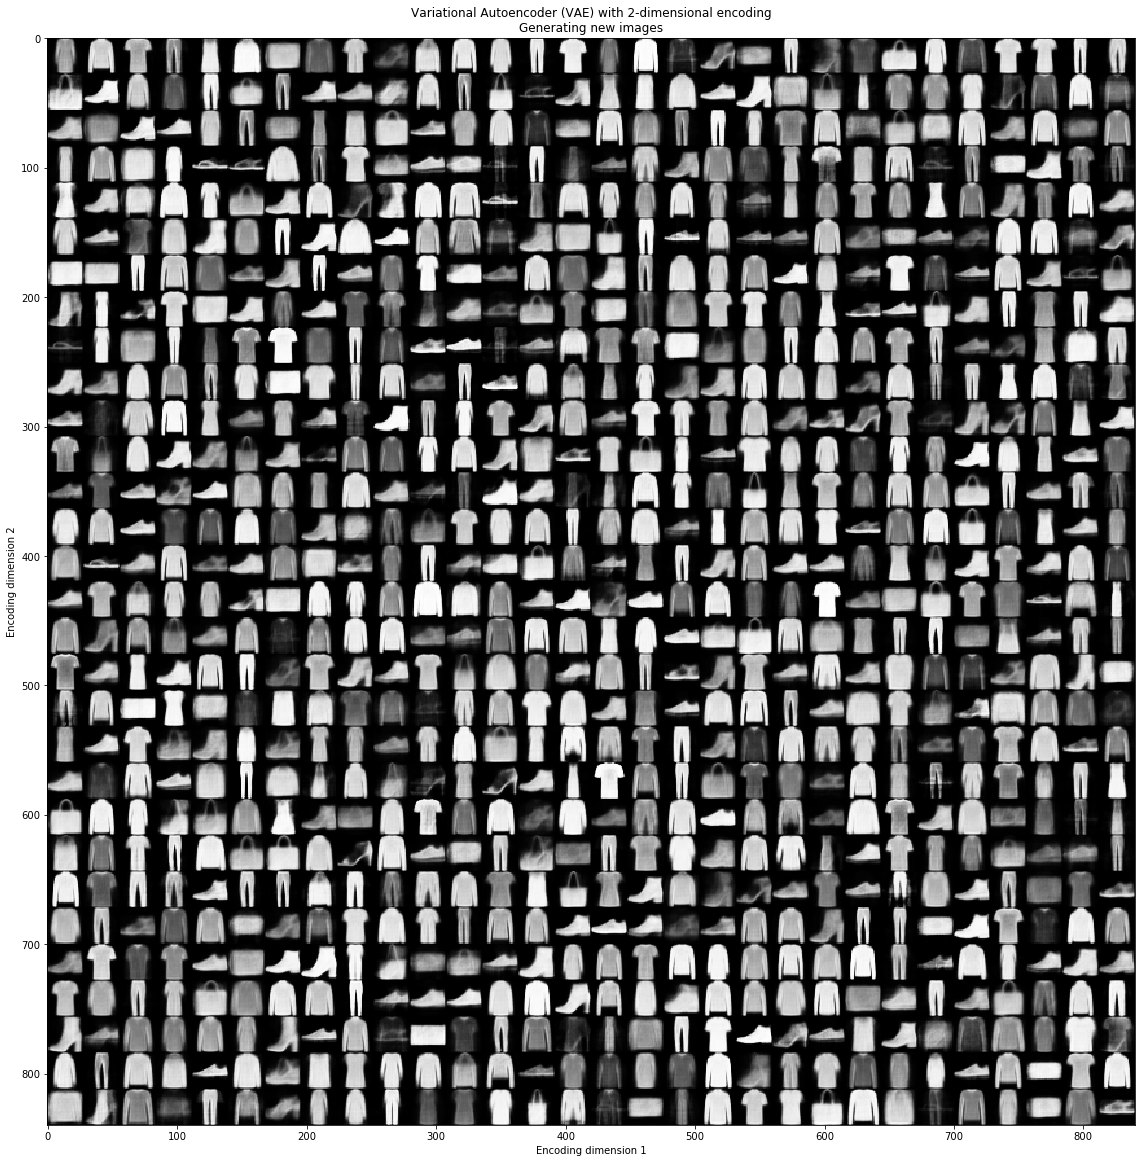

In [11]:
tsne = TSNE(n_components=2)
with tf.device(device_name="/CPU:0"):
    test_encoded_df = pd.DataFrame(
        data=tsne.fit_transform(
            X=variational_autoencoder.feature_extractor(
                x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])
            )
        ),
        columns=["Encoding_1", "Encoding_2"],
    )
test_encoded_df["Target"] = y_test

cluster_plot = (
    plotnine.ggplot(data=test_encoded_df)
    + plotnine.geom_point(
        mapping=plotnine.aes(x="Encoding_1", y="Encoding_2", fill="factor(Target)"),
        size=2,
        color="black",
    )
    + plotnine.xlab(xlab="Encoding dimension 1")
    + plotnine.ylab(ylab="Encoding dimension 2")
    + plotnine.ggtitle(title="Variational autoencoder with 2-dimensional encoding")
    + plotnine.theme_matplotlib()
)
cluster_plot.save(
    filename="/home/hamaad/Projects/autoencoders_tensorflow/variational_autoencoders_plot.png",
    height=6,
    width=8,
)

n = 30
data_size = 28
figure = np.zeros(shape=(data_size * n, data_size * n))

with tf.device(device_name="/CPU:0"):
    for i in range(n):
        for j in range(n):
            decoded = variational_autoencoder.decoder(
                np.array(
                    object=np.random.normal(
                        loc=0.0,
                        scale=1.0,
                        size=(1, variational_autoencoder.num_encoding),
                    )
                )
            ).numpy()
            figure[
                i * data_size : (i + 1) * data_size,
                j * data_size : (j + 1) * data_size,
            ] = decoded.reshape(data_size, data_size)

plt.figure(figsize=(20, 20))
plt.imshow(X=figure, cmap="Greys_r")
plt.title(
    label="Variational Autoencoder (VAE) with 2-dimensional encoding\nGenerating new images"
)
plt.xlabel(xlabel="Encoding dimension 1")
plt.ylabel(ylabel="Encoding dimension 2")
plt.savefig(
    fname="/home/hamaad/Projects/autoencoders_tensorflow/VAE_Generated_Images.png"
)
plt.show()

![](VAE_Generated_Images.png)

![](variational_autoencoders_plot.png)

## MNIST: 2 Dimensional Convolutional Autoencoders

For 2 dimensional convolution filters the idea is similar as for the 1 dimensional convolution filters. We will stick to our previously mentioned banking example to illustrate this point.

\begin{align*}
x = 
\begin{array}
{l}
\text{Period 1} \\ \text{Period 2} \\ \text{Period 3} \\ \text{Period 4} \\ \text{Period 5}
\end{array}
    \left[
    \begin{array}
    {ccc}
    \$0 & \$0 & \$0 \\
    \$0 & \$200 & \$0 \\
    \$100 & \$0 & \$0 \\
    \$0 & \$0 & \$300 \\
    \$0 & \$0 & \$0
    \end{array}
    \right]
\end{align*}

In the 2 dimensional tensor of raw transactions data now we have 5 historical time periods, i.e., the rows, and 3 different transaction types, i.e., the columns. We will use a kernel, $\alpha \in \mathbb{R}^{2\times3}$, to extract useful features from the raw data. The choice of such a kernel means that we are interested in finding a feature map across all 3 transaction types and 2 historical time periods. We will use a stride length of 1 and a valid convolution to extract features over different patches of the raw data. The following will illustrate this point where $x_{\text{patch}} \subset x$:

\begin{align*}
\alpha &=
    \left[
    \begin{array}
    {ccc}
    \alpha_{1,1} & \alpha_{1,2} & \alpha_{1,3} \\
    \alpha_{2,1} & \alpha_{2,2} & \alpha_{2,3}
    \end{array}
    \right] \\
x_{\text{patch}} &= 
    \left[
    \begin{array}
    {ccc}
    \$0 & \$0 & \$0 \\
    \$0 & \$200 & \$0
    \end{array}
    \right] \\
\mathbf{C}(x=x_{\text{patch}}|\alpha) &= x * \alpha \\
&= \sum_{t=1}^{2} \sum_{k=1}^{3} x_{t,k} \alpha_{t,k}
\end{align*}

The principles and ideas apply to 2 dimensional convolution filters as they do for their 1 dimensional counterparts there we will not repeat them here.

\begin{align*}
&X \in \mathbb{R}^{N \times 28 \times 28} \\
&E: \mathbb{R}^{N \times 28 \times 28} \rightarrow \mathbb{R}^{N \times K} \\
&D: \mathbb{R}^{N \times K} \rightarrow \mathbb{R}^{N \times 28 \times 28}
\end{align*}

### Results

The accuracy score for the MNIST classification task with a 2 dimensional convolutional autoencoder: 91.07%.

In [5]:
class Convolutional2DAutoencoder(tf.keras.Model):
    def __init__(
        self,
        filters,
        kernel_size,
        strides,
        pool_size,
        num_channels,
        dropout_rate,
    ):
        super().__init__()

        args, _, _, values = inspect.getargvalues(frame=inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)

        self.encoder = tf.keras.Sequential(
            layers=[
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2D(
                    filters=self.filters,
                    kernel_size=self.kernel_size,
                    strides=self.strides,
                    activation="elu",
                    padding="same",
                ),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(rate=self.dropout_rate),
                tf.keras.layers.Conv2D(
                    filters=self.filters,
                    kernel_size=self.kernel_size,
                    strides=self.strides,
                    activation="elu",
                    padding="same",
                ),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2D(
                    filters=self.filters,
                    kernel_size=self.kernel_size,
                    strides=self.strides,
                    activation="elu",
                    padding="same",
                ),
                tf.keras.layers.MaxPooling2D(strides=self.pool_size, padding="valid"),
            ]
        )

        self.decoder = tf.keras.Sequential(
            layers=[
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2D(
                    filters=self.filters,
                    kernel_size=self.kernel_size,
                    strides=self.strides,
                    activation="elu",
                    padding="same",
                ),
                tf.keras.layers.UpSampling2D(size=self.pool_size),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2D(
                    filters=self.filters,
                    kernel_size=self.kernel_size,
                    strides=self.strides,
                    activation="elu",
                    padding="same",
                ),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(rate=self.dropout_rate),
                tf.keras.layers.Conv2D(
                    filters=self.filters,
                    kernel_size=self.kernel_size,
                    strides=self.strides,
                    activation="elu",
                    padding="same",
                ),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2D(
                    filters=self.num_channels,
                    kernel_size=self.kernel_size,
                    strides=self.strides,
                    activation="sigmoid",
                    padding="same",
                ),
            ]
        )

    def call(self, x):
        encoding = self.encoder(x)
        return self.decoder(encoding)

In [6]:
@tf.function
def train_step(x, truth, model):
    with tf.GradientTape() as tape:
        decoding = model(x=x, training=True)
        loss = reconstruction_loss(y_true=truth, y_pred=decoding)
    gradients = tape.gradient(target=loss, sources=model.trainable_variables)
    optimizer.apply_gradients(grads_and_vars=zip(gradients, model.trainable_variables))
    train_loss(loss)


@tf.function
def test_step(x, truth, model):
    decoding = model(x=x, training=False)
    loss = reconstruction_loss(y_true=truth, y_pred=decoding)
    test_loss(loss)


convolutional2D_autoencoder = Convolutional2DAutoencoder(
    num_channels=1,
    filters=50,
    kernel_size=(8, 8),
    strides=(1, 1),
    pool_size=(4, 4),
    dropout_rate=0.5,
)
reconstruction_loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)
train_loss = tf.keras.metrics.Mean(name="train_loss")
test_loss = tf.keras.metrics.Mean(name="test_loss")

batch_size = 100
train_ds = (
    tf.data.Dataset.from_tensor_slices(
        tensors=(np.expand_dims(a=x_train, axis=3), np.expand_dims(a=x_train, axis=3))
    )
    .shuffle(buffer_size=10000, reshuffle_each_iteration=True)
    .batch(batch_size=batch_size)
)
test_ds = tf.data.Dataset.from_tensor_slices(
    tensors=(np.expand_dims(a=x_test, axis=3), np.expand_dims(a=x_test, axis=3))
).batch(batch_size=batch_size)

num_epochs = 50
for epoch in range(num_epochs):
    train_loss.reset_states()
    test_loss.reset_states()

    for x, truth in train_ds:
        train_step(x=x, truth=truth, model=convolutional2D_autoencoder)
    for x, truth in test_ds:
        test_step(x=x, truth=truth, model=convolutional2D_autoencoder)

    print("Epoch:", epoch + 1)
    print("Train loss:", train_loss.result())
    print("Test loss:", test_loss.result())

Epoch: 1
Train loss: tf.Tensor(0.017927162, shape=(), dtype=float32)
Test loss: tf.Tensor(0.008365157, shape=(), dtype=float32)
Epoch: 2
Train loss: tf.Tensor(0.0072247316, shape=(), dtype=float32)
Test loss: tf.Tensor(0.0052971677, shape=(), dtype=float32)
Epoch: 3
Train loss: tf.Tensor(0.0056471135, shape=(), dtype=float32)
Test loss: tf.Tensor(0.0042566927, shape=(), dtype=float32)
Epoch: 4
Train loss: tf.Tensor(0.0049252035, shape=(), dtype=float32)
Test loss: tf.Tensor(0.003812806, shape=(), dtype=float32)
Epoch: 5
Train loss: tf.Tensor(0.004528639, shape=(), dtype=float32)
Test loss: tf.Tensor(0.0030902738, shape=(), dtype=float32)
Epoch: 6
Train loss: tf.Tensor(0.0036916598, shape=(), dtype=float32)
Test loss: tf.Tensor(0.002905758, shape=(), dtype=float32)
Epoch: 7
Train loss: tf.Tensor(0.0033496444, shape=(), dtype=float32)
Test loss: tf.Tensor(0.0024707108, shape=(), dtype=float32)
Epoch: 8
Train loss: tf.Tensor(0.0030557495, shape=(), dtype=float32)
Test loss: tf.Tensor(0.00

KeyboardInterrupt: 

In [7]:
pipe_convolutional2D_autoencoder = Pipeline(
    steps=[
        ("scaler", MinMaxScaler(feature_range=(0.0, 1.0))),
        (
            "classifier",
            linear_model.LogisticRegression(max_iter=10000, random_state=666),
        ),
    ]
)

with tf.device(device_name="/CPU:0"):
    pipe_convolutional2D_autoencoder.fit(
        X=tf.keras.layers.Flatten(data_format="channels_last")(
            convolutional2D_autoencoder.encoder(
                np.expand_dims(a=sampled_x_train, axis=3)
            )
        ),
        y=sampled_y_train,
    )
    acc_convolutional2D_autoencoder = pipe_convolutional2D_autoencoder.score(
        X=tf.keras.layers.Flatten(data_format="channels_last")(
            convolutional2D_autoencoder.encoder(np.expand_dims(a=x_test, axis=3))
        ),
        y=y_test,
    )

print(
    "The accuracy score for the MNIST classification task with a 2 dimensional convolutional autoencoder: %.6f%%."
    % (acc_convolutional2D_autoencoder * 100)
)

The accuracy score for the MNIST classification task with a 2 dimensional convolutional autoencoder: 82.450000%.


In [ ]:
tsne = TSNE(n_components=2)
with tf.device(device_name="/CPU:0"):
    test_encoded_df = pd.DataFrame(
        data=tsne.fit_transform(
            X=tf.keras.layers.Flatten(data_format="channels_last")(
                convolutional2D_autoencoder.encoder(x_test)
            )
        ),
        columns=["Encoding_1", "Encoding_2"],
    )
test_encoded_df["Target"] = y_test

cluster_plot = (
    plotnine.ggplot(data=test_encoded_df)
    + plotnine.geom_point(
        mapping=plotnine.aes(x="Encoding_1", y="Encoding_2", fill="factor(Target)"),
        size=2,
        color="black",
    )
    + plotnine.xlab(xlab="Encoding dimension 1")
    + plotnine.ylab(ylab="Encoding dimension 2")
    + plotnine.ggtitle(title="2D convolutional autoencoder with 2-dimensional encoding")
    + plotnine.theme_matplotlib()
)
cluster_plot.save(
    filename="/home/hamaad/Projects/autoencoders_tensorflow/convolutional2D_autoencoders_plot.png",
    height=6,
    width=8,
)

![](convolutional2D_autoencoders_plot.png)

## Conclusion

We have shown how to use deep learning and Bayesian inference to learn a good representation in an unsupervised manner of unlabelled data $X$, i.e., 1 or 2 or perhaps more dimensional tensors per unit of analysis, that can then perhaps be used for supervised learning tasks where we may have a relatively small amount of labelled data.

## References

1. Goodfellow, I., Bengio, Y. and Courville A. (2016). Deep Learning (MIT Press).
2. Geron, A. (2017). Hands-On Machine Learning with Scikit-Learn & Tensorflow (O'Reilly).
3. Kingma, D. P., and Welling M. (2014). Auto-Encoding Variational Bayes (https://arxiv.org/abs/1312.6114).
4. http://scikit-learn.org/stable/#
5. https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
6. https://stackoverflow.com/questions/42177658/how-to-switch-backend-with-keras-from-tensorflow-to-theano
7. https://blog.keras.io/building-autoencoders-in-keras.html
8. https://keras.io
9. https://www.cs.cornell.edu/courses/cs1114/2013sp/sections/S06_convolution.pdf
10. http://deeplearning.net/tutorial/lstm.html 
11. Chollet, F. (2018). Deep Learning with Python (Manning).